# Домашнее задание 3. Алгоритмы кластеризации

Основная задача этого задания -- реализация одного из алгоритмов кластеризации. Кроме того, мы научимся подбирать параметры алгоритма, визуализируем результат кластеризации и попытаемся проанализировать природу полученных кластеров.

In [17]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from itertools import izip
from sklearn.neighbors import KDTree, NearestNeighbors

from collections import deque
# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Cчитываем данные, полученные в результате выполнения предыдущего домашнего задания, в `data frame` библиотеки `pandas`. Конвертируем данные в массив `numpy`.

In [434]:
data_df = pd.read_csv("hw2_out.csv", sep="\t", header=0, index_col="uid")
x = data_df.values

Алгоритм кластеризации, который необходимо реализовать, выбирается на основании Вашего логина на портале Техносферы. При проверке домашнего задания бадут осуществляться проверка логина и соответствующего алгоритма.

In [3]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры  - epsilon, min_pts)", 
    u"OPTICS. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[hash("d.penzar") % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm

Реализуем алгоритм кластеризации 'DBSCAN. (параметры  - epsilon, min_pts)'


Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [459]:
class Clustering:
    def __init__(self, epsilon, min_pts, leaf_size = 30, metric = "euclidean", p = 2):
        self.epsilon = epsilon
        self.min_pts = min_pts
        self.leaf_size = leaf_size # required for KDTree
        self.metric = metric # required for KDTree
        self.p = p # is required for minkowski metric
        return
        
    def fit(self, x, y=None):
        if  self.metric == "minkowski":
            kdTree = KDTree(x, p = self.p, leaf_size = self.leaf_size, metric = self.metric)
        else:
            kdTree = KDTree(x, leaf_size = self.leaf_size, metric = self.metric)
        self.x_len = len(x)
        self.labels_ = 0
        self.components_ = x.copy()
        self.labels = np.full(self.x_len, -1, dtype = 'i4') # mark all points as noise
        self.point_class = np.zeros(self.x_len, dtype = 'i1') # 0 - noise, 1 - border, 2 - core
        
        visited = np.zeros(self.x_len, dtype = 'i1')
        clusterIndex = -1


        for pointId in xrange(self.x_len):
            if visited[pointId]:
                continue
            visited[pointId] = 1
            neighbors = kdTree.query_radius(x[pointId], self.epsilon)[0]
            if len(neighbors) < self.min_pts:
                #mark as noise
                continue

            clusterIndex += 1 # new Cluster
            #expand_cluster
            self.labels[pointId] = clusterIndex
            self.point_class[pointId] = 2
            nei_core_queue = deque()
            nei_core_queue.extend(neighbors)

            while len(nei_core_queue) > 0:
                nei = nei_core_queue.popleft()
                if not visited[nei]:
                    visited[nei] = 1
                    nei_neighbours = kdTree.query_radius(x[nei], self.epsilon)[0]
                    if len(nei_neighbours) >= self.min_pts:
                        self.point_class[nei] = 2
                        nei_core_queue.extend(nei_neighbours)
                    else:
                        self.point_class[nei] = 1
                if self.labels[nei] == -1: 
                    self.labels[nei] = clusterIndex

        return self
    
    def predict(self, x):
        return self.labels
    
    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(x)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

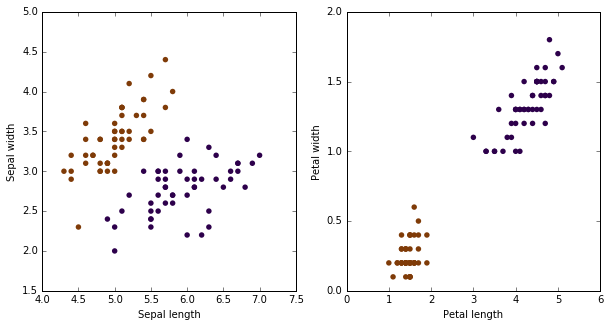

In [445]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [461]:
pred_iris = Clustering(epsilon = 0.3, min_pts = 3).fit_predict(x_iris)
canonicalPredict = sc.DBSCAN(eps=0.3, min_samples = 3).fit_predict(x_iris)
print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(canonicalPredict , pred_iris)

Adjusted Rand index for iris is: 1.00


Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

Стоит заметить, что по утверждению создателей алгоритма, результат кластеризации сильно зависит не только от eps и min_pts, но также и от выбранной метрики. Потому будем рассматривать четыре часто используемых случая - метрика Минковского для p = 1 (расстояние городских кварталов), p = 2 (Евклидова метрика), p = 9 (размер нашей размерности) и p = inf (Метрика Чебышева).  

Также создатели рекомендуют выбираеть min_pts из чисел, близких к размерности нашего пространства и больше 2(при 2 получается обрезание иерархической кластеризации, выбор 1 просто бессмысленнен). 

Выбирать же eps рекомендуется, каждой точке сопоставляя дистанцию до k-го наиблизжайшего соседа точки, где k равно выбранной minpts, выбирая затем eps из полученного графика как места перегиба функции плотности. При этом рекомендуется выбирать epsilon не очень большим (согласно правилу большого пальца это дает наилучший результат:)) 

Таким образом, план такой:
Для каждой метрики:
    для каждого pts от 4 до 20:
        рассчитать гистограмму расстояний до k-го соседа
        исходя из нее выбрать значения eps, для которых надо смотреть качество кластеризации
Для каждой метрики:
    построить 3D график (min_pts, eps, quality)
    
Неуточненными остаются две вещи - как выбирать eps и какую оценку качества использовать?

Для того, чтобы определиться с тем, как решать первую проблему, выполним для всех метрик при minpts = 9 + 1 = 10 (согласно более точной рекомендации создателей). 



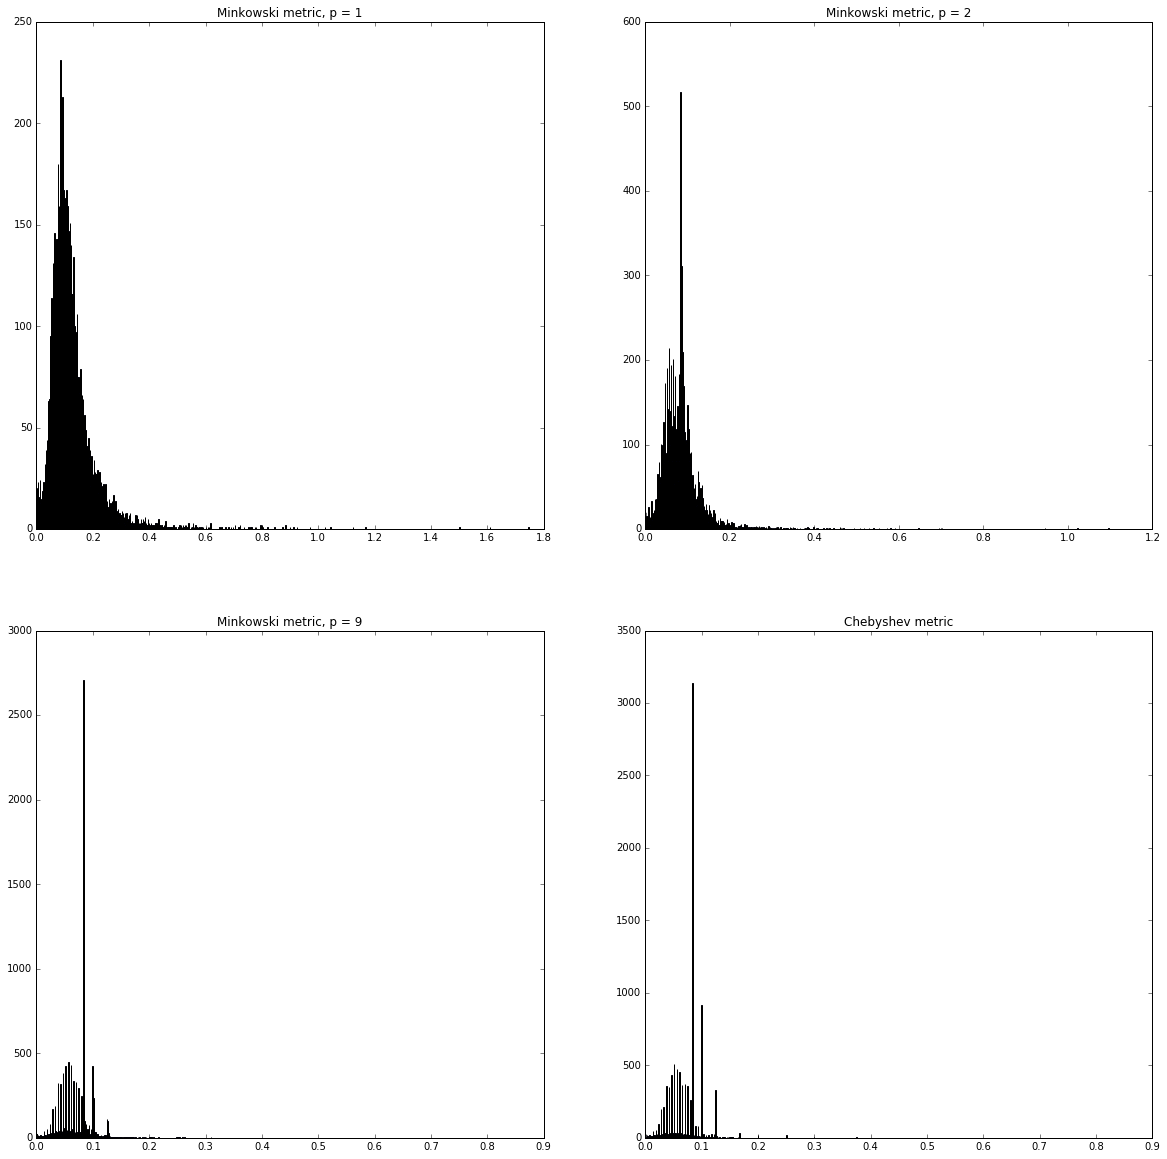

In [67]:
gridSize = 2
pl.figure(figsize=(20, 20))

i = 0
for i, p in enumerate((1, 2, 9)):
    pl.subplot(gridSize, gridSize, i + 1)
    pl.title("Minkowski metric, p = {}".format(p))
    tree = KDTree(x, leaf_size=5, p = p, metric = "minkowski")
    dist, _ = tree.query(x, k=10)
    kDist = dist.max(axis = 1)
    pl.hist(kDist, bins = 1000)

    
pl.subplot(gridSize, gridSize, 4)
pl.title("Chebyshev metric")
tree = KDTree(x, leaf_size=5, metric = "chebyshev")
dist, _ = tree.query(x, k=10)
kDist = dist[:, 9]
pl.hist(kDist, bins = 1000)
print # to avoid additional printing from hist

Из этих графиков видно, что для разных метрик полученные графики отличаются(хотя в определенных местах похожи).
Видно, что рекомендуемые авторами dbscan изгибы чаще наблюдаются при использовании последних двух метрик. 
Будем в дальнейшем использовать 

Вопрос с определением критерия качества еще более затруднен тем, что все три критерия дают предпочтение сферическим кластерам, что вовсе не гарантируется нашими данными и тем более не гарантируется DBScan. 

Sihouette мне кажется менее предвзятым (выберем лучшего из худших), потому буду использовать его. 

Сгенерируем последовательности minPts, eps, для которых мы будем определять качество кластеризации. Для этого для каждого minPts будем искать точки максимума и минимума в гистограмме расстояний до k-го близжайшего соседа.

In [262]:
def getBends(bins, minThreshold = 0.4, maxThreshold = 0.95):
    bends = list()
    before = 0
    maxNum = bins[0].sum() * maxThreshold # to big set of core points
    minNum = bins[0].sum() * minThreshold # to small set of core points
    
    for i in xrange(1, bins[0].size - 1):
        before += bins[0][i]
        if before < minNum:
            continue
        if (bins[0][i] < bins[0][i + 1] and bins[0][i] < bins[0][i - 1]) or\
        (bins[0][i] > bins[0][i + 1] and bins[0][i] > bins[0][i - 1]): # is min or max
            bends.append(bins[1][i])

        if before > maxNum:
            return bends
    return bends

In [277]:
binsNum = 250
metricList = [["minkowski", 2], ["minkowski", 9], ["chebyshev"]]
axis_dict = {"minkowski_2" : {}, "minkowski_9" : {}, "chebyshev" : {}}
#dt = { x[0] + "_" + str() : dict() for x in metricList}

In [278]:
for metric in metricList:
    if metric[0] == "minkowski":
        method_name = metric[0] + "_" + str(metric[1])
        tree = KDTree(x, leaf_size = 30, p = metric[1], metric = "minkowski")
    else:
        method_name = metric[0]
        tree = KDTree(x, leaf_size = 30, metric = metric[0])
        
    for min_pts in xrange(5, 25):
        dist, _ = tree.query(x, k = min_pts)
        kDist = dist.max(axis = 1)
        f = np.histogram(kDist, bins=binsNum)
        axis_dict[method_name][min_pts] = getBends(f)


In [279]:
print sum(len(x) for x in axis_dict["minkowski_9"].itervalues())

160


Видим, что для всех полученных точек считать качество кластеризации будет достаточно долго. Потому будем считать только для метрики Минковского с параметром 9.

In [280]:
#pointList = {}

for min_pts, epsilonList in  axis_dict["minkowski_9"].iteritems():
    print "Start calculating clusters for min_pts = {}".format(min_pts)
    dt = {}
    for epsilon in epsilonList:
        print "    Start calculating clusters for epsilon = {}".format(epsilon)
        dt[epsilon] = Clustering(epsilon=epsilon, min_pts = min_pts, metric = "minkowski", p = 9).fit_predict(x)
    pointList[min_pts] = dt
    

Start calculating clusters for min_pts = 5
    Start calculating clusters for epsilon = 0.0371289538858
    Start calculating clusters for epsilon = 0.0428113921049
    Start calculating clusters for epsilon = 0.0456526112145
    Start calculating clusters for epsilon = 0.048493830324
    Start calculating clusters for epsilon = 0.0513350494336
    Start calculating clusters for epsilon = 0.0570174876527
    Start calculating clusters for epsilon = 0.0598587067622
    Start calculating clusters for epsilon = 0.0626999258718
    Start calculating clusters for epsilon = 0.0655411449813
    Start calculating clusters for epsilon = 0.0712235832004
    Start calculating clusters for epsilon = 0.07406480231
    Start calculating clusters for epsilon = 0.0769060214195
    Start calculating clusters for epsilon = 0.0825884596386
    Start calculating clusters for epsilon = 0.0939533360768
    Start calculating clusters for epsilon = 0.0996357742959
    Start calculating clusters for epsilon = 

In [290]:
pointListSer = {}

for min_pts, epsilonList in  pointList.iteritems():
    dt = {}
    for epsilon in epsilonList:
        dt[epsilon] = list(pointList[min_pts][epsilon])
    pointListSer[min_pts] = dt

with open("pointsList.txt", "w") as listFile:
    listFile.write(json.dumps(pointListSer) + "\n")

In [309]:
def splitByClusters(x, labels):
    clusters = list()
    clusterIds = np.unique(labels)
    indexies = np.arange(len(x)) 
    for clId in clusterIds:
        if clId != -1:
            clusters.append(indexies[labels == clId])
    noise = indexies[labels == -1]
    return clusters, noise
            


def quality(x, y, metric, p = 2, takeNoiseInB = 0): # silhoette clusters quality
    if metric == "":
        distMatrix = smt.pairwise_distances(x, metric = metric, p = p)
    else:
        distMatrix = smt.pairwise_distances(x, metric = metric)
    clusters, noise = splitByClusters(x, y)
    
    silhoette = np.zeros(y.size)
    for cl in clusters:
        for el in cl:
            a = distMatrix[el, cl].sum() / (cl.size - 1)
            if len(clusters) > 1:
                b = min(distMatrix[el, cl1].sum() / cl1.size for cl1 in clusters if not cl1 is cl)
            elif takeNoiseInB != 0:
                b = distMatrix[el, noise].sum() / noise.size
            else:
                return 0

            if (takeNoiseInB == 1 or takeNoiseInB == 2) and len(clusters) > 1:
                b = min([b, distMatrix[el, noise].sum() / noise.size])
            silhoette[el] = (b - a) / max([a,b])
    if takeNoiseInB == 2:
        for el in noise:
            a = distMatrix[el, noise].sum() / (noise.size - 1)
            b = min(distMatrix[el, cl].sum() / cl.size for cl in clusters)
            silhoette[el] = (b - a) / max([a,b, 0.00000000001])
    """
    Implement quality criterion of your choice
    """
    if takeNoiseInB == 2:
        return silhoette.sum() / y.size
    else:
        return silhoette.sum() / (y != -1).sum()

#q = quality(x, db.labels_, metric = "euclidean", takeNoiseInB = 1)

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров. На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров.

In [311]:
import sys
#pointsCoors = {}

for min_pts, epsilonDict in pointList.iteritems():
    dt = {}
    sys.stdout.write("Start calculating quality for min_pts = {}\n".format(min_pts))
    for epsilon, labels in epsilonDict.iteritems():
        sys.stdout.write("    Start calculating quality for epsilon = {}\n".format(epsilon))
        dt[epsilon] = quality(x, labels, metric = "minkowski", p = 9, takeNoiseInB = 1)
    pointsCoors[min_pts] = dt

Start calculating quality for min_pts = 5
    Start calculating quality for epsilon = 0.0996357742959
    Start calculating quality for epsilon = 0.0456526112145
    Start calculating quality for epsilon = 0.0712235832004
    Start calculating quality for epsilon = 0.0570174876527
    Start calculating quality for epsilon = 0.0428113921049
    Start calculating quality for epsilon = 0.0655411449813
    Start calculating quality for epsilon = 0.0939533360768
    Start calculating quality for epsilon = 0.0626999258718
    Start calculating quality for epsilon = 0.119524308063
    Start calculating quality for epsilon = 0.0513350494336
    Start calculating quality for epsilon = 0.0825884596386
    Start calculating quality for epsilon = 0.0371289538858
    Start calculating quality for epsilon = 0.108159431625
    Start calculating quality for epsilon = 0.105318212515
    Start calculating quality for epsilon = 0.048493830324
    Start calculating quality for epsilon = 0.0769060214195
  

In [313]:
import json
with open("pointsCoord.txt", "w") as coordFile:
    coordFile.write(json.dumps(pointsCoors) + "\n")

#print pointsCoors

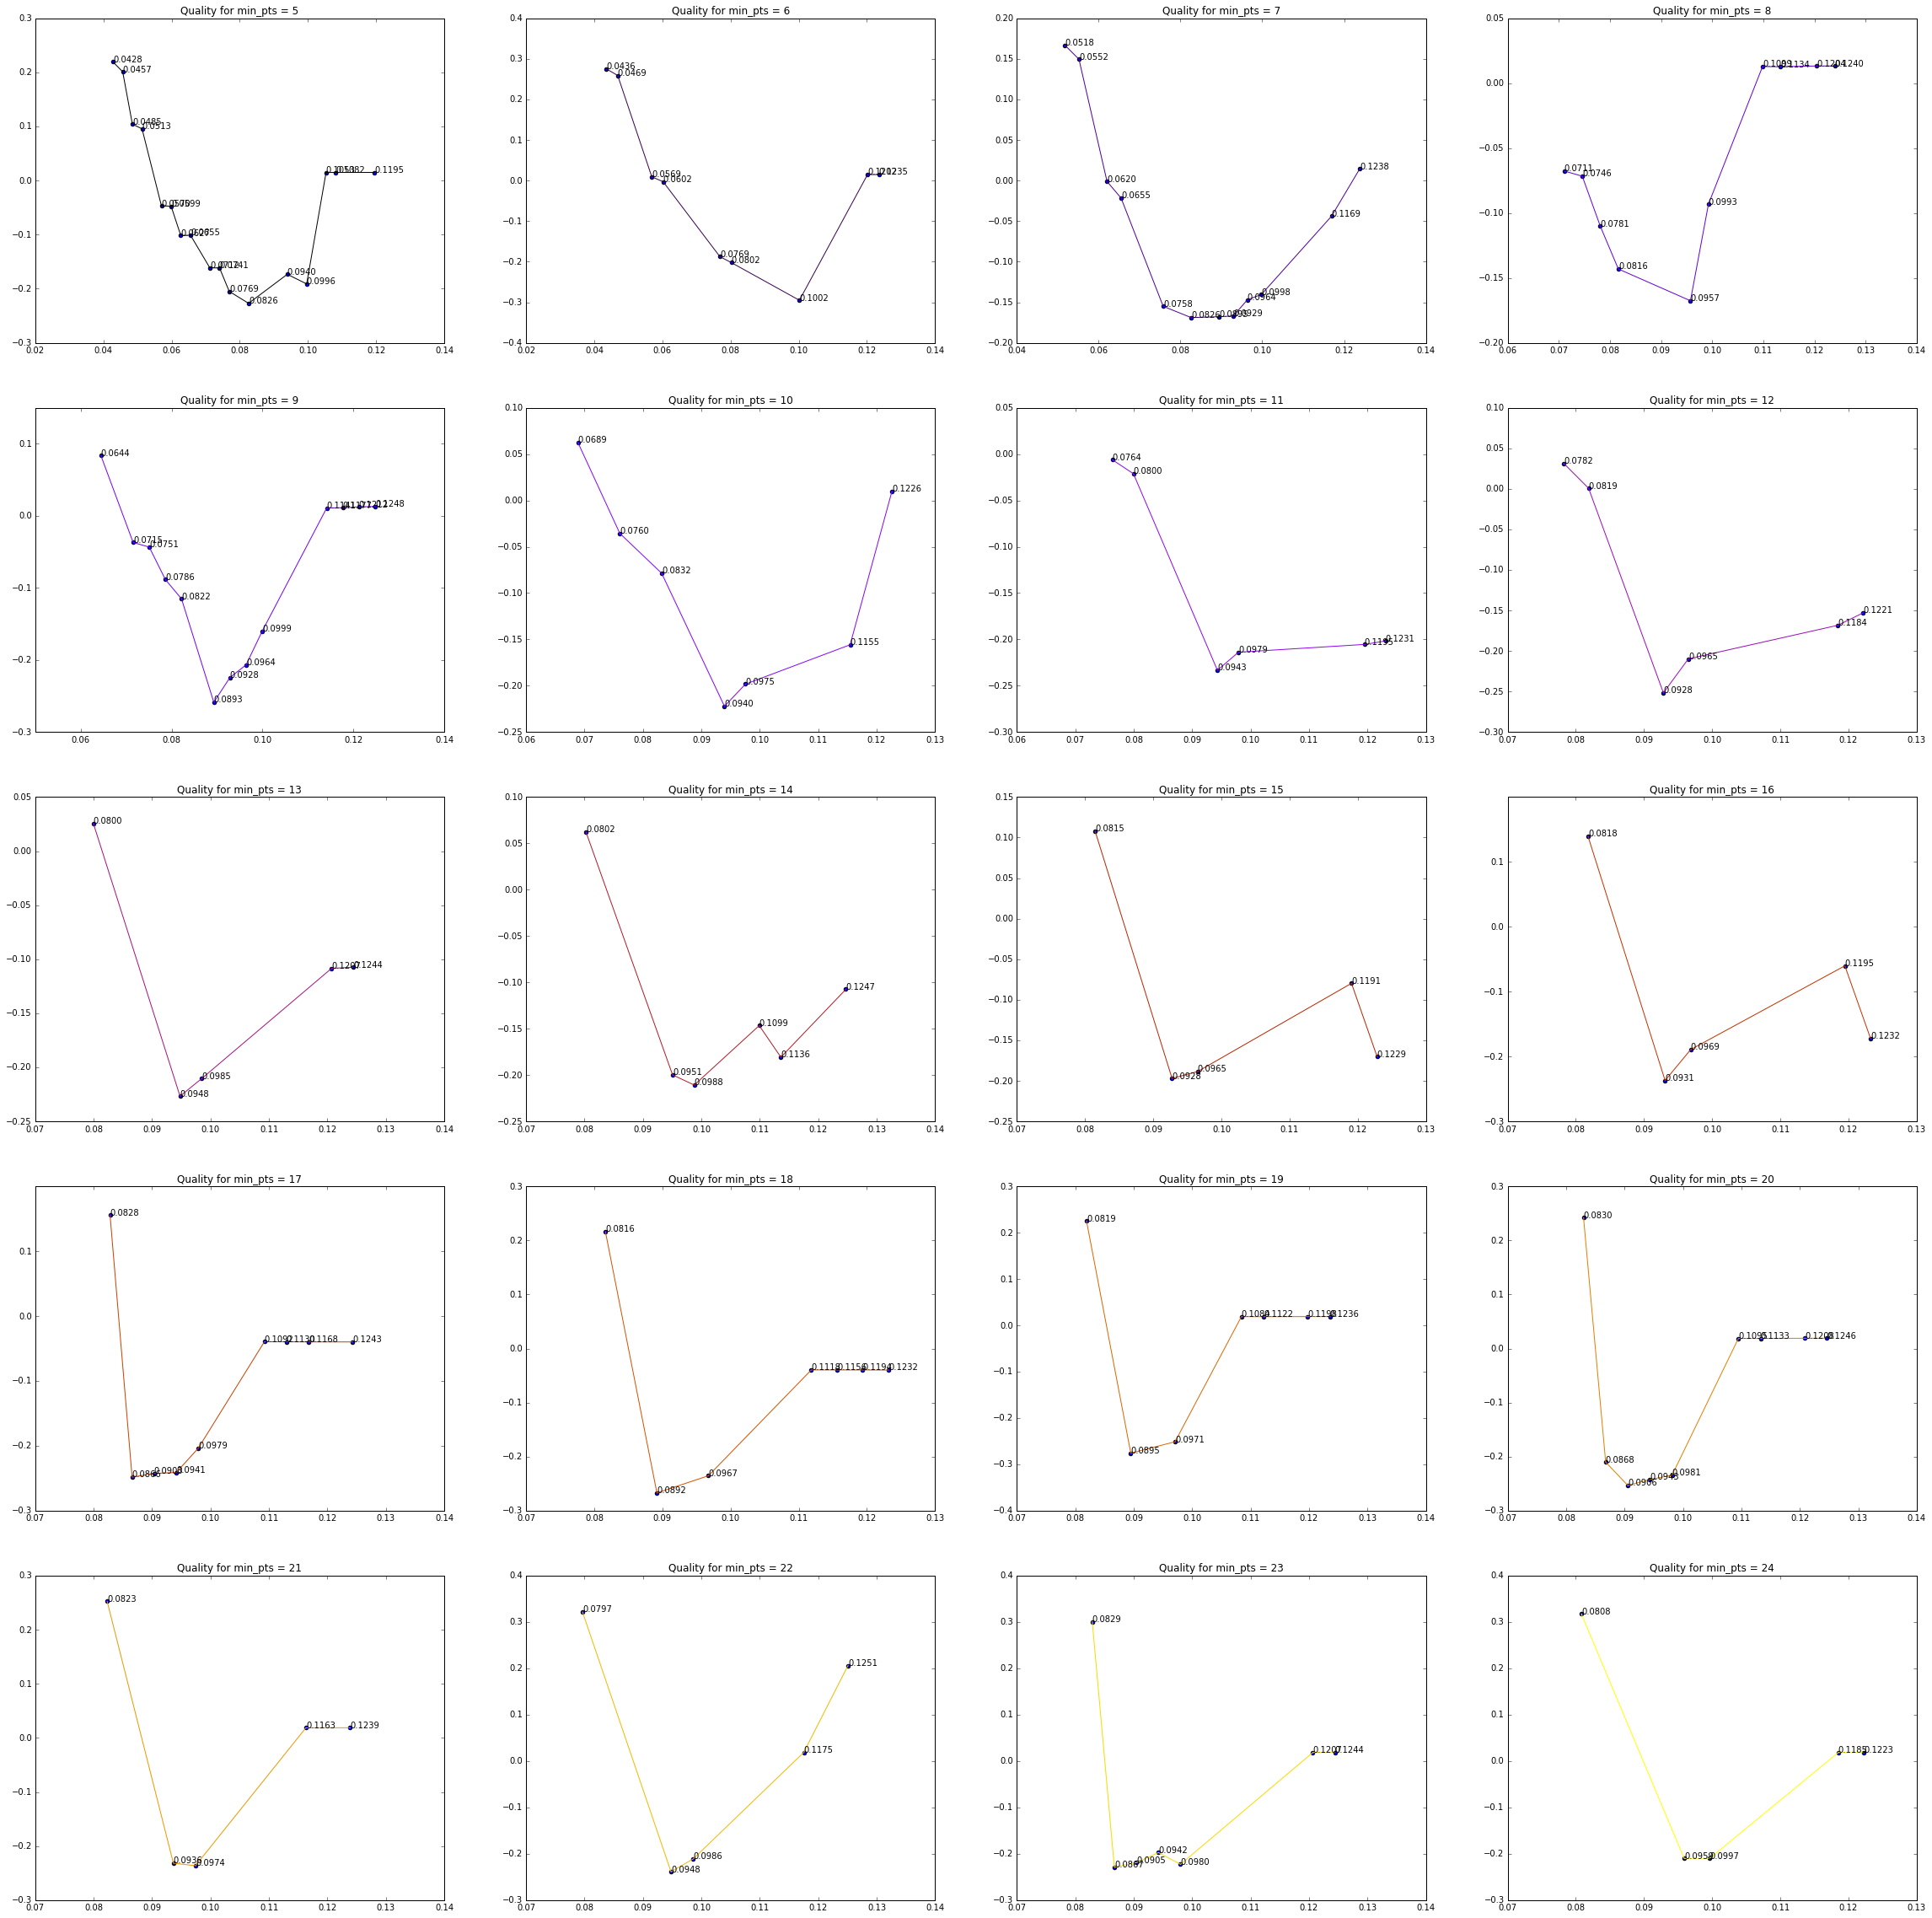

In [315]:
cmap = pl.get_cmap("gnuplot")
colors = [cmap(i) for i in np.linspace(0, 1, len(pointsCoors))]
pl.figure(figsize = (40,40))

gridSizeX = 5
gridSizeY = 4
for i, (min_pts, epsilonDict) in enumerate(pointsCoors.iteritems()):
    X = np.empty(len(epsilonDict))
    Y = np.empty(len(epsilonDict))
    pl.subplot(gridSizeX, gridSizeY, i + 1)
    for j, (x, y) in enumerate(epsilonDict.iteritems()):
        X[j] = x
        Y[j] = y
            
        plt.annotate(
        "{0:.4f}".format(x), 
        xy = (x, y))
    pl.title("Quality for min_pts = {}".format(min_pts))
    

    mask = ~ np.isnan(Y)
    Y = Y[mask]
    X = X[mask]
    order = np.argsort(X)
    X = X[order]
    Y = Y[order]

    pl.scatter(X, Y)
    pl.plot(X, Y, color = colors[i])


Из полученных графиков видно, что качество кластеризации сильно возрастает при eps приблизительно равном 0.119. 
В качестве minPts было выбрано 15, т.к для него отчетливо видно, что eps = 0.119 находится "на склоне" 

In [416]:
y = pointList[15][0.11909030034948649]
k = len(np.unique(y))

Визуализируем результаты кластеризации ([подсказка](http://anokhin.github.io/img/hw3_tsne-kmeans.png)). Можно ли сказать, что в двумерном пространстве объекты из одного кластера находятся недалеко? Какой вывод можно сделать о качестве кластеризации?

К сожалению, мой компьютер не выдерживает 11 тыс точек пытаемых TSNE и перестает делать что-либо(проверено 1.5 часовым ожиданием с verbose = 3). Потому сократил выборку до 5 тысяч, на которых алгоритм не падает. 

In [442]:
chList = []
for cl in np.unique(y):
    chPts = x[y == cl]
    if len(chPts) > 50:
        chPts = chPts[np.random.choice(len(chPts), size = len(chPts) * 0.435)]
    chList.append( (chPts, np.full(len(chPts), cl, dtype = 'i4')))

x_sample =  np.concatenate([z[0] for z in chList], axis = 0)
y_sample = np.concatenate([z[1] for z in chList], axis = 0)

#mincfunc = lambda X, Y : ss.distance.minkowski(X, Y, p = 9)

[-1  0  1  2  3  4  5]


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 5006
[t-SNE] Computed conditional probabilities for sample 2000 / 5006
[t-SNE] Computed conditional probabilities for sample 3000 / 5006
[t-SNE] Computed conditional probabilities for sample 4000 / 5006
[t-SNE] Computed conditional probabilities for sample 5000 / 5006
[t-SNE] Computed conditional probabilities for sample 5006 / 5006
[t-SNE] Mean sigma: 0.072505
[t-SNE] Iteration 10: error = 25.8415586, gradient norm = 0.0372539
[t-SNE] Iteration 20: error = 25.0548686, gradient norm = 0.0687584
[t-SNE] Iteration 30: error = 21.0438639, gradient norm = 0.0648703
[t-SNE] Iteration 40: error = 20.4620711, gradient norm = 0.0588833
[t-SNE] Iteration 50: error = 20.5207938, gradient norm = 0.0547569
[t-SNE] Iteration 60: error = 17.7785033, gradient norm = 0.0463676
[t-SNE] Iteration 70: error = 17.8860818, gradient norm = 0.0531216
[t-SNE] Iteration 80: error = 18.2079389, gradient norm = 0

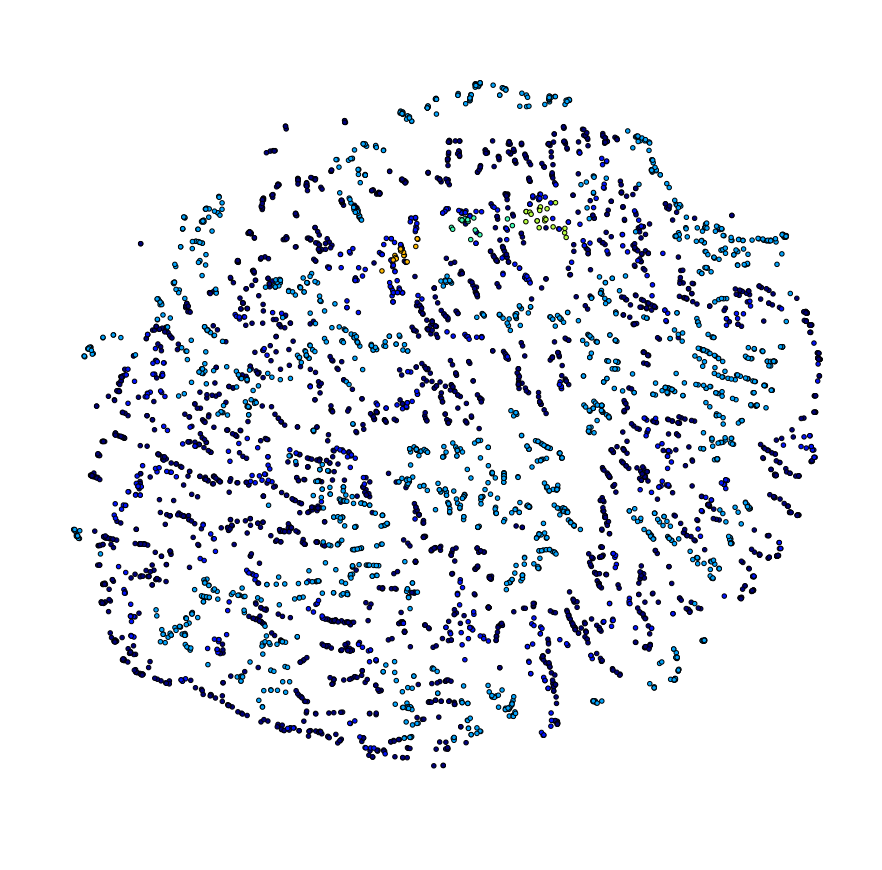

In [469]:
tsne = sm.TSNE(n_components=2, verbose=3, n_iter=1000, learning_rate=1000.0)
z = tsne.fit_transform(x_sample)

# Color map
cm = pl.get_cmap('jet')
pl.figure(figsize=(15, 15))
pl.scatter(z[:, 0], z[:, 1], c=map(lambda c: cm(1.0 * c / k), y_sample))
pl.axis('off')
pl.show()

Попробуем проанализировать полученные кластеры. Для того, чтобы интерпретировать "суть" каждого из кластеров, построим [radar plot](http://www.wikiwand.com/en/Radar_chart), отображающий их центроиды. Посмотрите на графики и попробуйте объяснить, каким поведением можно охарактеризовать каждый из полученных кластеров? Есть ли среди кластеров похожие?

Реализация радара позаимствована отсюда: 
http://www.science-emergence.com/Matplotlib/MatplotlibGallery/RadarChartMatplotlibRougier/

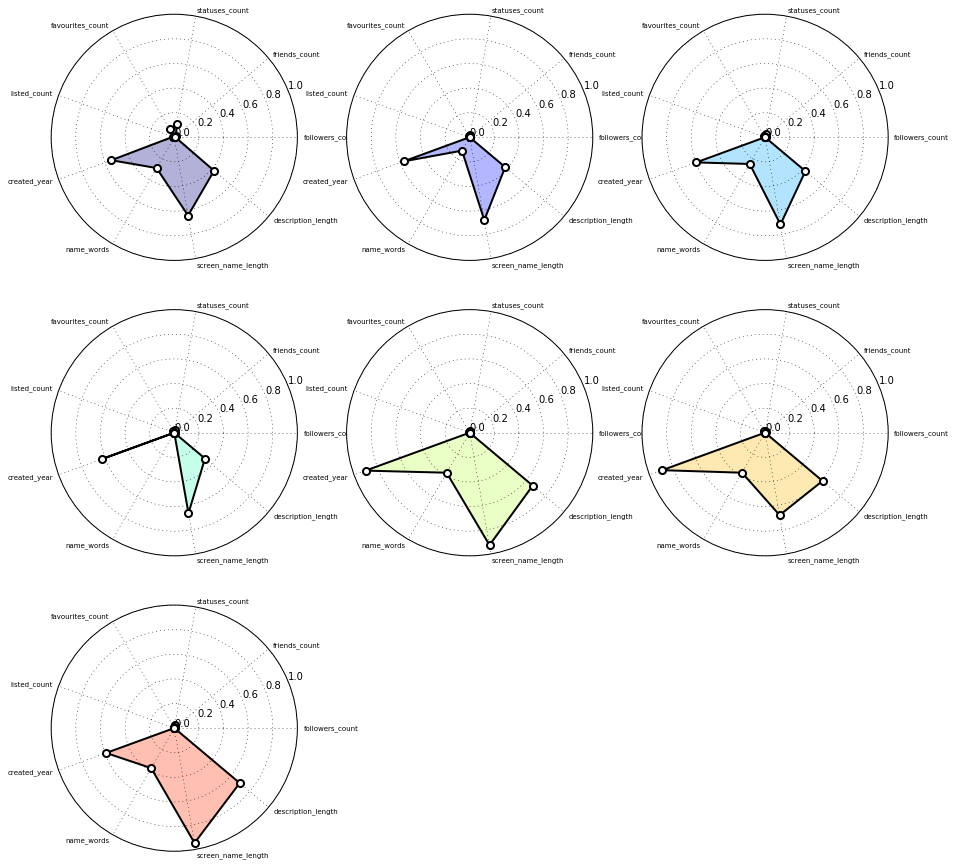

In [465]:
def radar(centroid, features, axes, color):
    # Set ticks to the number of features (in radians)
    t = np.arange(0, 2*np.pi, 2*np.pi/len(features))
    plt.xticks(t, [])

    # Set yticks from 0 to 1
    plt.yticks(np.linspace(0, 1, 6))

    # Draw polygon representing centroid
    points = [(x, y) for x, y in zip(t, centroid)]
    points.append(points[0])
    points = np.array(points)
    codes = [path.Path.MOVETO,] + [path.Path.LINETO,] * (len(centroid) - 1) + [ path.Path.CLOSEPOLY ]
    _path = path.Path(points, codes)
    _patch = patches.PathPatch(_path, fill=True, color=color, linewidth=0, alpha=.3)
    axes.add_patch(_patch)
    _patch = patches.PathPatch(_path, fill=False, linewidth = 2)
    axes.add_patch(_patch)

    # Draw circles at value points
    plt.scatter(points[:,0], points[:,1], linewidth=2, s=50, color='white', edgecolor='black', zorder=10)

    # Set axes limits
    plt.ylim(0, 1)

    # Draw ytick labels to make sure they fit properly
    for i in range(len(features)):
        angle_rad = i/float(len(features))*2*np.pi
        angle_deg = i/float(len(features))*360
        ha = "right"
        if angle_rad < np.pi/2 or angle_rad > 3*np.pi/2: ha = "left"
        plt.text(angle_rad, 1.05, features[i], size=7, horizontalalignment=ha, verticalalignment="center")

# Some additiola imports
import matplotlib
import matplotlib.path as path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Choose some nice colors
matplotlib.rc('axes', facecolor = 'white')
# Make figure background the same colors as axes 
fig = plt.figure(figsize=(15, 15), facecolor='white')

cm = pl.get_cmap('jet')

clusters = np.unique(y)
for j, cluster in enumerate(clusters):    
    x_c = x[y == cluster]
    centroid = x_c.mean(axis=0)    
    # Use a polar axes
    axes = plt.subplot(3, 3, j + 1, polar=True)
    radar(centroid, data_df.columns.values, axes, cm(1.0 * j / k))

plt.show()

In [468]:
for cl in clusters:
    if cl == -1:
        print "Noise: {}".format((y == cl).sum())
    else:
        print "Cluster {} : {}".format(cl, (y == cl).sum())

Noise: 482
Cluster 0 : 5465
Cluster 1 : 1367
Cluster 2 : 4075
Cluster 3 : 16
Cluster 4 : 19
Cluster 5 : 19


Заметно, что 2 кластер(достаточно большой) заметно выделяется из остальных. Последние три кластера мало чем отличаются между собой, и похожи кластер номер 1. Возможно, их стоит отнести туда. 

Поздравляем, Вы завершили домашние задания по модулю "Алгоритмы кластеризации". Надеемся, что это было интересно.